<a href="https://colab.research.google.com/github/larregui/UFOCloseEncounters/blob/main/UFO_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [ ]:
import pandas as pd #data frame operations
import numpy as np #arrays and math functions
#from scipy.stats import uniform #for training and test splits
#import statsmodels.api as sm  # statistical models (including regression)
#import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt #2D plotting
import seaborn as sns #seaborn for plotting
#from sklearn.linear_model import LinearRegression
#import plotly.graph_objs as go
#from plotly import tools
#from plotly.offline import iplot, init_notebook_mode

#Import Datasets

In [ ]:
ufo = pd.read_csv("/content/newufo.csv")
wea = pd.read_csv("/content/drive/MyDrive/Datasets/consolidated_weather_V03.csv")

#Data Cleanup

In [ ]:
#change datatype for the following columns
ufo["latitude"] = pd.to_numeric(ufo["latitude"], errors="coerce")
ufo['datetime'] = (pd.to_datetime(ufo['datetime'], format='%Y/%m/%d'))
ufo['date posted'] = (pd.to_datetime(ufo['date posted'], format='%Y/%m/%d'))
#add column day
ufo['day'] = pd.DatetimeIndex(ufo['datetime']).day
#drop unnecessary columns
cols2drop=[ 'Unnamed: 0','duration (hours/min)','date posted']
ufo=ufo.drop(columns=cols2drop)

In [ ]:
# Creating seasons column
# Seasons of the ufo appearances
def output_season_from(x):
    
    if x in range(3,6):
        return "Spring"
    if x in range(6,9):
        return "Summer"
    if x in range(9,12):
        return "Autumn"
    if x == 12 or x == 1 or x == 2:
        return "Winter"

ufo["season"] = ufo['month'].apply(output_season_from)

In [ ]:
wea['dateInt']=wea['year'].astype(str) + wea['month'].astype(str).str.zfill(2)+ wea['mday'].astype(str).str.zfill(2)
wea['datetime'] = pd.to_datetime(wea['dateInt'], format='%Y%m%d')
wea['state']=wea['state'].str.lower()
wea['city']=wea['city'].str.lower()
wea['shape']=wea['shape'].str.lower()
cols2drop=[ 'colour','month','pressure','heatindex','windchill', 'precip', 
            'wgust', 'wdire','dewpt','wspd','hum','conds', 'mday','year','hour','id','dateInt']

wea=wea.drop(columns=cols2drop)

# Shows all the null values
#print(wea.isnull().sum())

wea=wea.dropna()
wea.shape

(50963, 12)

#Merge datatsets

In [ ]:
df = pd.merge(ufo, wea, on=["city", "state", "datetime", "shape"])
df.describe()

,duration (seconds),latitude,longitude,year,month,military_base_dist,airport_dist,day,temp,hail,rain,vis,thunder,fog,tornado,snow
count,3.535600e+04,35356.000000,35356.000000,35356.000000,35356.000000,35356.000000,35356.000000,35356.000000,35356.000000,35356.0,35356.000000,35356.000000,35356.000000,35356.000000,35356.000000,35356.000000
mean,3.640002e+03,38.383515,-95.421423,2007.543896,6.889043,5000.481879,3.779888,15.307642,-0.040161,0.0,0.021976,-0.003462,0.005968,0.004101,0.000028,0.004299
std,2.908908e+05,5.596983,18.223826,4.605761,3.327509,1132.724850,3.878917,8.871921,1.006675,0.0,0.146609,1.054241,0.077022,0.063910,0.005318,0.065428
min,1.000000e-02,19.063889,-170.478889,1997.000000,1.000000,1579.967092,0.022381,1.000000,-5.419079,0.0,0.000000,-2.740390,0.000000,0.000000,0.000000,0.000000
25%,3.000000e+01,34.134722,-114.888542,2004.000000,4.000000,3872.748270,1.231377,8.000000,-0.699044,0.0,0.000000,0.064273,0.000000,0.000000,0.000000,0.000000
50%,1.800000e+02,38.998889,-89.213611,2008.000000,7.000000,5314.815203,2.740357,15.000000,0.077412,0.0,0.000000,0.064273,0.000000,0.000000,0.000000,0.000000
75%,6.000000e+02,42.011111,-80.699722,2012.000000,10.000000,5868.691832,4.821439,23.000000,0.731270,0.0,0.000000,0.064273,0.000000,0.000000,0.000000,0.000000
max,5.262320e+07,70.636944,-66.984722,2014.000000,12.000000,7238.415091,56.585655,31.000000,4.102724,0.0,1.000000,30.898139,1.000000,1.000000,1.000000,1.000000


#Classifier

In [ ]:
df.loc[df['tornado'] ==1, 'Credible'] = 'NO'
df.loc[df['fog'] ==1, 'Credible'] = 'NO'
df.loc[df['snow'] ==1, 'Credible'] = 'NO'
df.loc[df['rain'] ==1, 'Credible'] = 'NO'
df.loc[df['thunder'] ==1, 'Credible'] = 'NO'
df.loc[df['hail'] ==1, 'Credible'] = 'NO'
#df.loc[df['vis'] >= 0.064273, 'Credible'] = 'NO'
df.loc[df['airport_dist'] <= 1.6, 'Credible'] = 'NO'
df.loc[df['military_base_dist'] <= 1.6, 'Credible'] = 'NO'
df.loc[(df.month == 1) & (df.day == 1), "Credible"] = 'NO'
df.loc[(df.month == 7) & (df.day == 4), "Credible"] = 'NO'

In [ ]:
df['Credible'] = df.Credible.replace(np.NaN, 'YES')
df.head()

,datetime,city,state,country,shape,duration (seconds),comments,latitude,longitude,time,year,month,coord,military_base_name,military_base_dist,airport_name,airport_dist,day,season,temp,hail,rain,vis,thunder,fog,tornado,snow,Credible
0,1997-10-10,mesa,az,us,sphere,30.0,A small dark purple quad-thruster craft hoveri...,33.422222,-111.821944,17:00,1997,10,"('33.4222222', -111.8219444)",Eareckson AS,3454.409479,Mesa Hospital Medical Center Heliport,0.311086,10,Autumn,1.660974,0,0,0.064273,0,0,0,0,NO
1,1997-10-10,bonaire,ga,us,triangle,300.0,Triangular Object Sighted at Very Close Range,32.543611,-83.596111,20:00,1997,10,"('32.5436111', -83.59611109999999)",Eareckson AS,5404.265953,Warner Robins Air Park,7.589948,10,Autumn,0.629105,0,0,0.900445,0,0,0,0,YES
2,1998-10-10,las vegas,nv,us,cigar,600.0,White&#44 vertical cigar shape floating around...,36.175000,-115.136389,17:30,1998,10,"('36.1750000', -115.1363889)",Eareckson AS,3589.816966,City Hall Complex Heliport,0.518080,10,Autumn,1.242096,0,0,2.868935,0,0,0,0,NO
3,1998-10-10,mooresville,nc,us,light,2.0,Star gazing in back yard with telescope and bi...,35.584722,-80.810278,20:50,1998,10,"('35.5847222', -80.8102778)",Eareckson AS,5775.016814,Hunter Construction Heliport,3.038387,10,Autumn,0.016113,0,0,0.064273,0,0,0,0,YES
4,1998-10-10,delano,tn,us,fireball,15.0,I came home from work one night and I seen a b...,35.265000,-84.553333,23:50,1998,10,"('35.2650000', -84.55333329999999)",Eareckson AS,5452.721410,Chilhowee Gliderport,5.153607,10,Autumn,-0.096269,0,0,0.064273,0,0,0,0,YES


Text(0.5, 1.0, 'Credibilty Distribution')

<Figure size 1440x576 with 0 Axes>

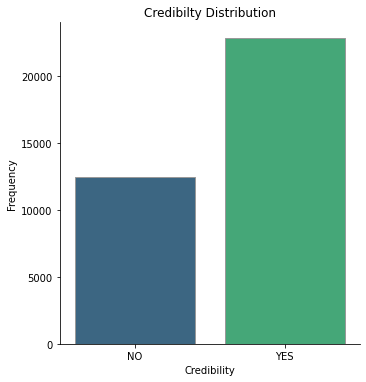

In [ ]:
plt.figure(figsize=(20,8))
sns.catplot(x=df["Credible"], kind="count",
            palette="viridis", edgecolor=".6",
            data=df.sort_values("Credible"))
plt.xlabel('Credibility')
plt.ylabel('Frequency')
plt.title("Credibilty Distribution")

In [ ]:
ufo['month'] = ufo['month'].astype(float)
ufo['day'] = ufo['day'].astype(float)

# Logistic Regression

In [ ]:
cols2drop=['datetime','duration (seconds)', 'comments', 'latitude', 'longitude', 'time', 'country', 'coord', 'military_base_name',	'military_base_dist',	'airport_name',	'airport_dist', 
              'temp', 'day',	'hail',	'rain',	'vis',	'thunder',	'fog',	'tornado',	'snow', 'year']
data=df.drop(columns=cols2drop)
data1=df.drop(columns=cols2drop)

In [ ]:
from sklearn.preprocessing import LabelEncoder

data = data.apply(LabelEncoder().fit_transform)
data.head()

,city,state,shape,month,season,Credible
0,3835,3,15,9,0,0
1,585,10,16,9,0,1
2,3301,33,2,9,0,0
3,3987,27,11,9,0,1
4,1492,42,8,9,0,1


In [ ]:
data.dtypes

city        int64
state       int64
shape       int64
month       int64
season      int64
Credible    int64
dtype: object

In [ ]:
# Assign X (data) and y (target)
data = data.drop(columns=["Credible"])
X = data
y = data1["Credible"]
print(X.shape, y.shape)

(35356, 5) (35356,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [ ]:
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.6468680469133009
Testing Data Score: 0.646905758569974


In [ ]:
predictions = classifier.predict(X_test)
print(f"First 7 Predictions:   {predictions[:7]}")
print(f"First 7 Actual labels: {y_test[:7].tolist()}")

First 7 Predictions:   ['YES' 'YES' 'YES' 'YES' 'YES' 'YES' 'YES']
First 7 Actual labels: ['NO', 'YES', 'YES', 'NO', 'YES', 'YES', 'NO']


In [ ]:
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True).head(10)

,Prediction,Actual
0,YES,NO
1,YES,YES
2,YES,YES
3,YES,NO
4,YES,YES
5,YES,YES
6,YES,NO
7,YES,YES
8,YES,NO
9,YES,YES


In [ ]:
y_test

10183     NO
34787    YES
22452    YES
8180      NO
7118     YES
        ... 
179      YES
16828    YES
14760    YES
15739     NO
7620     YES
Name: Credible, Length: 8839, dtype: object

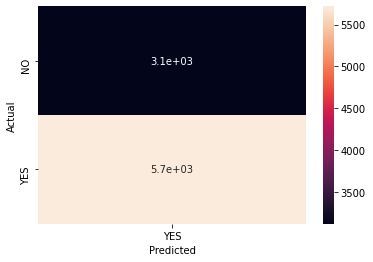

In [ ]:
confusion_matrix = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [ ]:
df_orig=data1

#y is the same as above

for label, original_class in zip(y, df_orig['Credible']):
    print('Original Class: ' + str(original_class))
    print('Encoded Label: ' + str(label))
    print('-' * 12)

Streaming output truncated to the last 5000 lines.
Encoded Label: NO
------------
Original Class: NO
Encoded Label: NO
------------
Original Class: YES
Encoded Label: YES
------------
Original Class: NO
Encoded Label: NO
------------
Original Class: NO
Encoded Label: NO
------------
Original Class: YES
Encoded Label: YES
------------
Original Class: YES
Encoded Label: YES
------------
Original Class: YES
Encoded Label: YES
------------
Original Class: NO
Encoded Label: NO
------------
Original Class: YES
Encoded Label: YES
------------
Original Class: YES
Encoded Label: YES
------------
Original Class: YES
Encoded Label: YES
------------
Original Class: YES
Encoded Label: YES
------------
Original Class: YES
Encoded Label: YES
------------
Original Class: NO
Encoded Label: NO
------------
Original Class: YES
Encoded Label: YES
------------
Original Class: NO
Encoded Label: NO
------------
Original Class: YES
Encoded Label: YES
------------
Original Class: YES
Encoded Label: YES
-------

# Arima

In [ ]:
ufo1= ufo[ufo["year"] == 2012]
ufo2= ufo[ufo["year"] == 2013]
dfmap = ufo1.loc[:,['datetime']]
count = dfmap['datetime'].value_counts()
date = ufo1['datetime']
count = pd.DataFrame(count, date)
count = count.rename(columns={' ': 'datetime','datetime': 'count'})
dfmap = dfmap.merge(count, on='datetime', how='left')
count


,count
datetime,
2012-10-10,18
2012-10-10,18
2012-10-10,18
2012-10-10,18
2012-10-10,18
...,...
2012-09-09,24
2012-09-09,24
2012-09-09,24


In [ ]:
dfmap2 = ufo2.loc[:,['datetime']]
count2 = dfmap2['datetime'].value_counts()
date2 = ufo2['datetime']
count2 = pd.DataFrame(count2, date2)
count2 = count2.rename(columns={' ': 'datetime','datetime': 'count'})
dfmap2 = dfmap2.merge(count2, on='datetime', how='left')
count2

,count
datetime,
2013-10-10,13
2013-10-10,13
2013-10-10,13
2013-10-10,13
2013-10-10,13
...,...
2013-09-09,14
2013-09-09,14
2013-09-09,14


In [ ]:
count=count.T
count2=count2.T

In [ ]:
count.dropna()
count2.dropna()

datetime,2013-10-10,2013-10-10,2013-10-10,2013-10-10,2013-10-10,2013-10-10,2013-10-10,2013-10-10,2013-10-10,2013-10-10,2013-10-10,2013-10-10,2013-10-10,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-11,2013-10-01,2013-10-01,2013-10-01,2013-10-01,2013-10-01,2013-10-01,...,2013-09-07,2013-09-07,2013-09-07,2013-09-07,2013-09-07,2013-09-07,2013-09-07,2013-09-07,2013-09-07,2013-09-07,2013-09-07,2013-09-07,2013-09-07,2013-09-08,2013-09-08,2013-09-08,2013-09-08,2013-09-08,2013-09-08,2013-09-08,2013-09-08,2013-09-08,2013-09-08,2013-09-08,2013-09-08,2013-09-08,2013-09-09,2013-09-09,2013-09-09,2013-09-09,2013-09-09,2013-09-09,2013-09-09,2013-09-09,2013-09-09,2013-09-09,2013-09-09,2013-09-09,2013-09-09,2013-09-09
count,13,13,13,13,13,13,13,13,13,13,13,13,13,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,17,17,17,17,17,17,...,27,27,27,27,27,27,27,27,27,27,27,27,27,13,13,13,13,13,13,13,13,13,13,13,13,13,14,14,14,14,14,14,14,14,14,14,14,14,14,14


In [ ]:
df_train = count.median().T
df_test = count2.median().T
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults as arima_results
#
model = ARIMA(df_train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 6319
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -18193.057
Method:                       css-mle   S.D. of innovations              4.307
Date:                Thu, 10 Dec 2020   AIC                          36400.113
Time:                        03:29:37   BIC                          36447.372
Sample:                             1   HQIC                         36416.482
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.045      0.021      0.983      -0.088       0.090
ar.L1.D.y     -0.1680      0.013    -13.357      0.000      -0.193      -0.143
ar.L2.D.y     -0.0357      0.013     -2.802      0.0

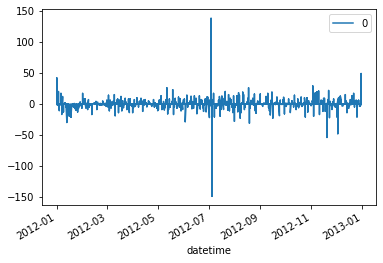

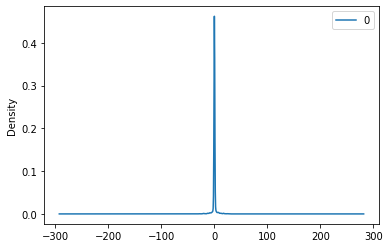

                  0
count  6.319000e+03
mean  -9.470519e-07
std    4.307001e+00
min   -1.490011e+02
25%   -1.132106e-03
50%   -1.132106e-03
75%   -1.132106e-03
max    1.379989e+02


In [ ]:
from pandas import DataFrame

# plot residual errors
def residuals_plot(model_fit):
    residuals = DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()

    # plot kernel density estimation
    residuals.plot(kind='kde')
    plt.show()

    # descriptibe statistics
    print(residuals.describe())

residuals_plot(model_fit)

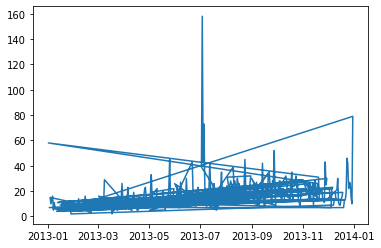

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
hist = [x for x in df_train]
predictions = list()

for t in range(iterations):
    model = ARIMA(hist, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs=df_test
    hist.append(obs)
    print('predicted={:03f}, expected={:03f}'.format(float(yhat), obs))
#rmse=sqrt(mean_squared_error(df_test, predictions))
#print('Test RMSE: %.3f'% rmse)
plt.plot(df_test)
plt.plot(predictions, color='red')
plt.show()